# Biodiversity in Phoenix, Arizona
#### Author: Linus Ghanadan
#### [Link to GitHub repository](https://github.com/linusghanadan/phoenix_biodiversity)

## Introduction
#### Purpose
The purpose of this analysis is to better understand and visualize biodiversity in Phoenix and highlight areas where biodiversity is declining. Specifically, the final map will show a map of Phoenix displayed on 100 meter grid-cells colored based on the area's 2020 Biodiversity Intactness Index (BII), which is a score from 0 to 1. In addition, areas where BII declined from greater than 0.75 in 2017 to less than 0.75 in 2020 will be highlighted in a seperate color.

#### Highlights of analysis
- Add basemap with Contextily
- Fetch items from Microsoft Planetary Computer (MPC) catalog using search criteria
- Clip biodiversity raster based on polygon from shapefile of Arizona subdivisions
- Calculate percent of area with BII>0.75 in 2017 and 2020
- Visualize 2020 biodiversity and changes from 2017

#### Dataset descriptions
1. The primary dataset used in this analysis estimates terrestrial Biodiversity Intactness as a 100-meter gridded maps for years 2017 to 2020. The data contained in the dataset comes from Impact Observatory and Vizzuality, and they generated the data using a database of spatially referenced observations of biodiversity across 32,000 sites and over 750 studies. The data was accessed from the Microsoft Planetary Computer (MPC) catalog.
2. A dataset from the U.S. Census Bureau was used to clip biodiversity raster.

#### References to datasets
1. Impact Observatory & Vizzuality. 2022. “Biodiversity Intactness.” Accessed via Microsoft Planetary Computer (MPC) Catalog. [https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview).
2. U.S. Census Bureau. 2022. "2022 TIGER/Line Shapefiles: County Subdivision". [https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)

## 1) Import libraries

In [1]:
# Load libraries
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from shapely.geometry import Polygon

from pystac_client import Client
import planetary_computer

import rasterio
from rasterio.plot import show
import contextily as ctx

## 2) Read in data
#### Biodiversity data

In [2]:
# Access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Set Phoenix bounding box
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search catalog
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Get items from search as list
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [3]:
# Store individual items
item_2020 = items[0]
item_2017 = items[3]

# Check CRS
item_2017.properties['proj:epsg']

4326

In [37]:
# Store raster data from items
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)

# Print original dimensions and coords
print('Original 2017 raster', bii_2017.dims, bii_2017.coords, '\n')

# Remove length band dimension
# Print updated dimensions and coords
bii_2020 = bii_2020.squeeze()
bii_2017 = bii_2017.squeeze()

# Remove coordinates associated to band
bii_2020 = bii_2020.drop('band')
bii_2017 = bii_2017.drop('band')

# Print updated dimensions and coords
print('Updated 2017 raster', bii_2017.dims, bii_2017.coords, '\n')

Original 2017 raster ('band', 'y', 'x') Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0 

Updated 2017 raster ('y', 'x') Coordinates:
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0 



#### Arizona shapefile

In [56]:
# Read in Arizona shapefile
arizona = gpd.read_file("data/tl_2022_04_cousub/tl_2022_04_cousub.shp")

# Select Phoenix subdivision
phoenix = arizona[arizona['NAME'] == 'Phoenix']

# Convert CRS to match MPC data
phoenix = phoenix.to_crs('4326')

# Check for matching CRS (should return True)
item_2017.properties['proj:epsg'] == phoenix.crs

True

## 3) Create basic map of Phoenix subdivision

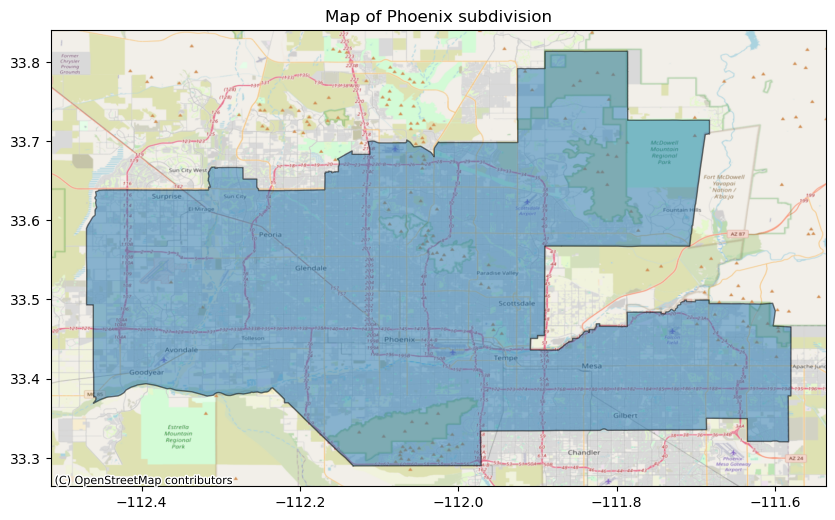

In [8]:
# Set axis for Phoenix
ax = phoenix.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add basemap from OpenStreetMap using Contextily
ctx.add_basemap(ax, crs=phoenix.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("Map of Phoenix subdivision")

# Display map
plt.show()

## 4) Clip rasters and calculate percent area with BII > 0.75 for 2017 and 2020

In [18]:
# Clip the rasters to Phoenix geometry
bii_2017_clipped = bii_2017.rio.clip(phoenix.geometry, crs='4326')
bii_2020_clipped = bii_2020.rio.clip(phoenix.geometry, crs='4326')

# Calculate percent area with BII>0.75
percent_area_2017 = (np.sum(bii_2017_clipped > 0.75) / np.sum(bii_2017_clipped > 0)) * 100
percent_area_2020 = (np.sum(bii_2020_clipped > 0.75) / np.sum(bii_2020_clipped > 0)) * 100

# Print percents
print(f"Percentage of area with BII>0.75 in 2017: {percent_area_2017:.2f}%")
print(f"Percentage of area with BII>0.75 in 2020: {percent_area_2020:.2f}%")

Percentage of area with BII>0.75 in 2017: 7.13%
Percentage of area with BII>0.75 in 2020: 6.49%


## 5) Visualize 2020 BII and changes from 2017

In [33]:
# Make raster representing the area with BII>0.75 in 2017 that was lost by 2020
lost_area = (bii_2017_clipped > 0.75) & (bii_2020_clipped < 0.75)

# Check that lost area raster has same spatial reference dimension as original rasters (should return True)
if lost_area.spatial_ref == bii_2017.spatial_ref == bii_2017.spatial_ref:
    print('True')

True


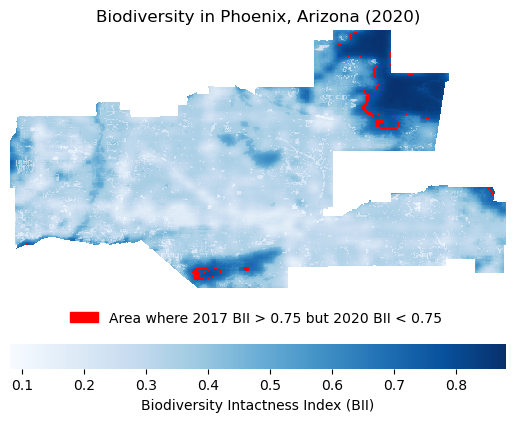

In [34]:
# Convert bools to binary values
lost_area_numeric = lost_area.astype(int)

# Replace zeros with NaN
cropped_lost_area = lost_area_numeric.where(lost_area_numeric == 1)

# Define custom colormap for the lost area
custom_cmap = ListedColormap(['red'])

# Plot figure and axis with custom colorbar
fig, ax = plt.subplots()
im = bii_2020_clipped.plot(ax=ax, cmap='Blues', add_colorbar=False)
cropped_lost_area.plot(ax=ax, cmap=custom_cmap, add_colorbar=False)
cbar = plt.colorbar(im, orientation='horizontal', pad=0.15)
cbar.set_label('Biodiversity Intactness Index (BII)')
cbar.outline.set_visible(False)

# Create legend patch
red_patch = Patch(color='red', label='Area where 2017 BII > 0.75 but 2020 BII < 0.75')

# Add legend below the figure
legend_ax = fig.add_axes([0.80, 0.2, 0.02, 0.12])
legend_ax.legend(handles=[red_patch], ncol=1, frameon=False)
legend_ax.axis('off')

# Add title
title_text = 'Biodiversity in Phoenix, Arizona (2020)'
ax.set_title(title_text)

# Remove axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Remove frame around the entire figure
ax.set_frame_on(False)

# Show the plot
plt.show()

From this map, we can see how the edges of certain areas in Phoenix, which had relatively high BII, decrease from greater than 0.75 to less than 0.75. In particular, this can be seen in the North East area of Phoenix, in addition to one spot in South Central Phoenix.